In [1]:
import argparse
from pathlib import Path
from tqdm import tqdm

# torch

import torch

from einops import repeat

# vision imports

from PIL import Image
from torchvision.utils import make_grid, save_image

# dalle related classes and utils

from dalle_pytorch import DiscreteVAE, OpenAIDiscreteVAE, VQGanVAE, DALLE
from dalle_pytorch.tokenizer import *

In [2]:
raw_text = "아우터는 색상이 브라운 소재가 우븐 핏이 노멀인 재킷이다. 하의는 색상이 블랙 소재가 우븐 핏이 노멀인 팬츠이다."

In [3]:
from easydict import EasyDict

DALLE_CFG = EasyDict()

# argument parsing

DALLE_CFG.VQGAN_PATH = "/opt/ml/taming-transformers/logs/2021-12-13T16-23-29_custom_vqgan/checkpoints/VQGAN_blue.ckpt"   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.VQGAN_CFG_PATH = "/opt/ml/taming-transformers/logs/2021-12-13T16-23-29_custom_vqgan/configs/VQGAN_blue.yaml"   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.DALLE_PATH = "/opt/ml/DALLE-pytorch/dalle.pt"   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.TAMING = True    # use VAE from taming transformers paper
DALLE_CFG.IMAGE_TEXT_FOLDER = './'
DALLE_CFG.BPE_PATH = None
DALLE_CFG.RESUME = os.path.exists(DALLE_CFG.DALLE_PATH)

# DALLE_CFG.EPOCHS = 20
# DALLE_CFG.BATCH_SIZE = 54
DALLE_CFG.LEARNING_RATE = 3e-4
DALLE_CFG.GRAD_CLIP_NORM = 0.5

# DALLE_CFG.MODEL_DIM = 512
DALLE_CFG.TEXT_SEQ_LEN = 128
DALLE_CFG.DEPTH = 12
DALLE_CFG.HEADS = 8
DALLE_CFG.DIM_HEAD = 64
DALLE_CFG.REVERSIBLE = True

In [4]:
# import from huggingface transformers
from transformers import AutoTokenizer
  
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
# model = AutoModelWithLMHead.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5")

encoded_dict = tokenizer(
    raw_text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=DALLE_CFG.TEXT_SEQ_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,  # for RoBERTa
)
encoded_dict=encoded_dict.to('cuda')
input_ids = encoded_dict["input_ids"]
attention_mask = encoded_dict["attention_mask"]

tensor([[    0,  6164,  2115,  2259,  8817,  2052, 10424,  4642,  2116,  1469,
          2862,  1887,  2052,   766,  2149,  2179, 10224, 28674,    18, 19975,
          2259,  8817,  2052,  5676,  4642,  2116,  1469,  2862,  1887,  2052,
           766,  2149,  2179, 15144, 28674,    18,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [6]:
from dalle_pytorch import VQGanVAE
from pathlib import Path

DALLE_CFG.VOCAB_SIZE = tokenizer.vocab_size # refer to EDA, there are only 333 words total. but input_ids index should be in within 0 ~ 52000: https://github.com/boostcampaitech2-happyface/DALLE-Couture/blob/pytorch-dalle/EDA.ipynb

dalle_path='/opt/ml/DALLE-pytorch/dalle.pt'
#assert dalle_path.exists(), 'DALL-E model file does not exist'

loaded_obj = torch.load(dalle_path, map_location=torch.device('cuda'))

dalle_params, _ , weights = loaded_obj['hparams'], loaded_obj['vae_params'], loaded_obj['weights']

vae_klass = VQGanVAE
vae = vae_klass(
    vqgan_model_path=DALLE_CFG.VQGAN_PATH, 
    vqgan_config_path=DALLE_CFG.VQGAN_CFG_PATH
    )

DALLE_CFG.IMAGE_SIZE = vae.image_size

dalle_params = dict(        
    **dalle_params
)

DALLE_CFG.IMAGE_SIZE = vae.image_size

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from /opt/ml/taming-transformers/logs/2021-12-13T16-23-29_custom_vqgan/checkpoints/VQGAN_blue.ckpt and /opt/ml/taming-transformers/logs/2021-12-13T16-23-29_custom_vqgan/configs/VQGAN_blue.yaml


In [7]:
dalle_params

{'num_text_tokens': 32000,
 'text_seq_len': 64,
 'depth': 12,
 'heads': 8,
 'dim_head': 64,
 'reversible': False,
 'loss_img_weight': 7,
 'attn_types': ('full',),
 'ff_dropout': 0.7,
 'attn_dropout': 0.7,
 'stable': False,
 'shift_tokens': False,
 'rotary_emb': False}

In [8]:
from model import DALLE_Klue_Roberta
from clipmodel import *
from einops import repeat

dalle = DALLE_Klue_Roberta(
    vae = vae, 
    wte_dir="/opt/ml/DALLE-pytorch/roberta_large_wte.pt",
    wpe_dir="/opt/ml/DALLE-pytorch/roberta_large_wpe.pt",
    **dalle_params
    )
dalle.load_state_dict(weights)
dalle.to('cuda')
input_ids=repeat(input_ids,'() n -> b n',b=5)
#print(input_ids)
#print(input_ids.shape)
#raw_text=raw_text.to('cuda')
# https://github.com/lucidrains/DALLE-pytorch/blob/main/dalle_pytorch/dalle_pytorch.py#L454-L510
clip_model = torch.load("fashionclip_fn.pt")
clip_model.to('cuda')
images = dalle.generate_images(input_ids, mask = attention_mask,clip=clip_model,raw_text=raw_text)
#images.shape # (4, 3, 256, 256)

1024 16 16
torch.Size([5, 3, 256, 256])


/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2233: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Input Text: 아우터는 색상이 브라운 소재가 우븐 핏이 노멀인 재킷이다. 하의는 색상이 블랙 소재가 우븐 핏이 노멀인 팬츠이다.
probability: 0.20085719227790833


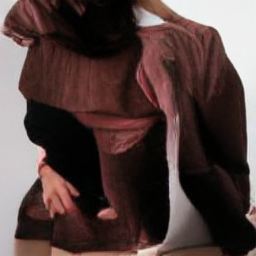

probability: 0.2007923722267151


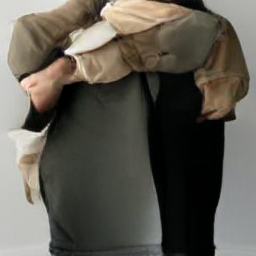

probability: 0.20067806541919708


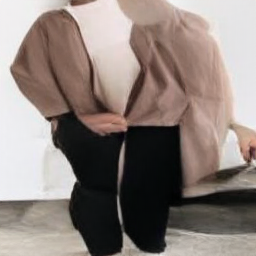

probability: 0.1990816444158554


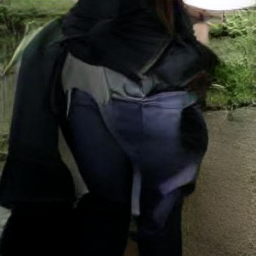

probability: 0.1985906958580017


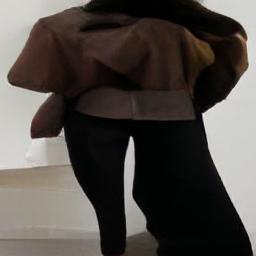

In [9]:
from torchvision.utils import make_grid, save_image
from PIL import Image
lgits=images[1]
probs = torch.nn.Softmax(dim=1)(lgits)
import matplotlib.pyplot as plt
print(f'Input Text: {raw_text}')
### Sorting 통해 text랑 image사이 거리가 가장 가까운 순으로 출력 ### 
for idx, prob in sorted(enumerate(probs[0]),key = lambda x: x[1], reverse = True):
    print(f'probability: {prob.item()}')
    grid = make_grid(images[0][idx], nrow=1, padding=0, pad_value=0)
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    display(im)

In [10]:
print(images[1])

tensor([[6.5843, 6.5758, 6.5837, 6.5846, 6.5733]], device='cuda:0')
